In [1]:
!pip install tensorflow

In [4]:
import pandas as pd
import tensorflow as tf

In [5]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [7]:
#listing all the classes
import os
labels=os.listdir('garbage_classification')
print(labels)

['brown-glass', 'shoes', 'trash', 'battery', 'white-glass', 'clothes', 'metal', 'cardboard', 'paper', 'green-glass', 'plastic', 'biological']


In [8]:
!pip install matplotlib

In [9]:
#counting total number of classes in each class.
dataset_count = {}
for label in labels:
    label_path = os.path.join('garbage_classification', label)
    count = len(os.listdir(label_path))
    dataset_count[label] = count

print(dataset_count)

{'brown-glass': 607, 'shoes': 1977, 'trash': 697, 'battery': 945, 'white-glass': 775, 'clothes': 5325, 'metal': 769, 'cardboard': 891, 'paper': 1050, 'green-glass': 629, 'plastic': 865, 'biological': 985}


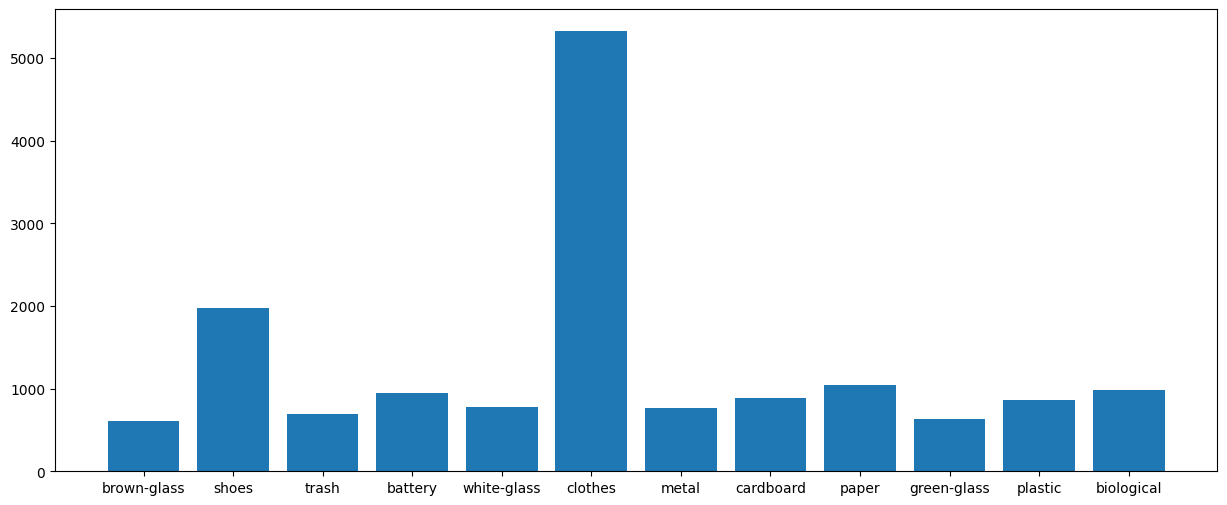

In [10]:
#representing in a graph
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.bar(labels,dataset_count.values())
plt.show()

In [11]:
# making train and test directory
os.makedirs('dataset', exist_ok=True)
train_dir = os.path.join('dataset', "train")
test_dir = os.path.join('dataset', "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [12]:
#splittting the dataset into 80:20 ratio
import shutil
import random
for label in os.listdir('garbage_classification'):
    label_path = os.path.join('garbage_classification', label)
    if os.path.isdir(label_path):
        os.makedirs(os.path.join(train_dir, label), exist_ok=True) # creating directories of each class train
        os.makedirs(os.path.join(test_dir, label), exist_ok=True) # creating directories of each class in test
        images = os.listdir(label_path)
        random.shuffle(images)

        #spliting the dataset
        split_idx = int(len(images) * 0.8)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        #copying the images
        for img in train_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(train_dir, label, img))
        for img in test_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(test_dir, label, img))


In [13]:
# setting train and test path
train_path = os.path.join('dataset', "train")
test_path = os.path.join('dataset', "test")
print(train_path)
print(test_path)

dataset/train
dataset/test


In [14]:
#Setting the image height and width
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [15]:
#resizing the images in train directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 12409 files belonging to 12 classes.


2025-01-13 09:46:25.645618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10368 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [16]:
#resizing the images in test directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3106 files belonging to 12 classes.


In [17]:
class_names = train_dataset.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [18]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [19]:
#preprocessing the train and test dataset
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
from tensorflow.keras.layers import BatchNormalization, Dropout

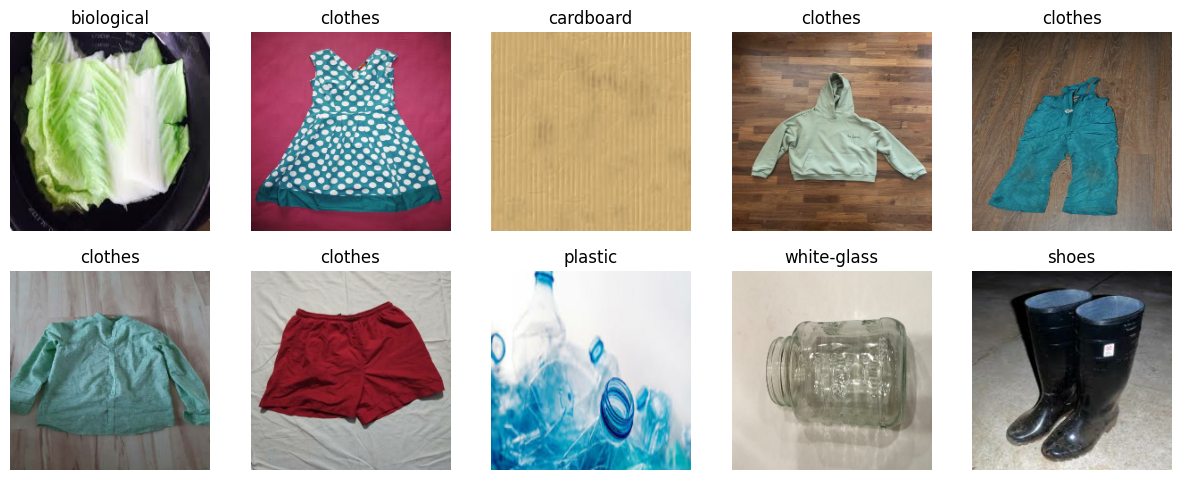

In [22]:
#displaying atleast 10 images after preprocessing and after auto tuning
import matplotlib.pyplot as plt
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(min(10, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.show()


In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))


In [25]:
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

In [26]:
#Data augementation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Model definition (example)
model = tf.keras.Sequential([
    data_augmentation,
    SeparableConv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    SeparableConv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    SeparableConv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(len(class_names), activation='softmax')
])





In [28]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [29]:
# Compile the model
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [31]:
model.build(input_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3))

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 separable_conv2d_3 (Separa  (32, 222, 222, 32)        155       
 bleConv2D)                                                      
                                                                 
 batch_normalization_4 (Bat  (32, 222, 222, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 111, 111, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (32, 111, 111, 32)        0         
                                                      

In [33]:
os.makedirs('modes')

In [34]:
# Checkpoint highest accuracy
#will save the best version of the model with highest accuracy
checkpoint_high_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{'modes'}/base_model_highest_accuracy.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Checkpoint lowest loss
#will save the best version of the model with lowest loss
checkpoint_low_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{'modes'}/base_model_lowest_loss.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

In [35]:
import time
start_time = time.time()
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[checkpoint_high_acc, checkpoint_low_loss, early_stopping])
end_time = time.time()
print("Training is stopped")

Epoch 1/50


2025-01-13 09:46:38.729946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-13 09:46:39.722123: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2025-01-13 09:46:40.757316: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f29538a5420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 09:46:40.757370: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-01-13 09:46:40.762750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736761600.869997    1144 device_compiler.h:186] Compiled 

388/388 [==============================] - ETA: 0s - loss: 2.4584 - accuracy: 0.2635
Epoch 1: val_accuracy improved from -inf to 0.34288, saving model to modes/base_model_highest_accuracy.keras

Epoch 1: val_loss improved from inf to 2.19198, saving model to modes/base_model_lowest_loss.keras
388/388 [==============================] - 130s 320ms/step - loss: 2.4584 - accuracy: 0.2635 - val_loss: 2.1920 - val_accuracy: 0.3429
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 2.3256 - accuracy: 0.3157
Epoch 2: val_accuracy did not improve from 0.34288

Epoch 2: val_loss improved from 2.19198 to 2.18925, saving model to modes/base_model_lowest_loss.keras
388/388 [==============================] - 124s 318ms/step - loss: 2.3256 - accuracy: 0.3157 - val_loss: 2.1893 - val_accuracy: 0.3429
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 2.2819 - accuracy: 0.3269
Epoch 3: val_accuracy did not improve from 0.34288

Epoch 3: val_loss did not improve fro

In [39]:
print('Computational Time =', (end_time-start_time)/60,'minutes')

Computational Time = 36.974613813559216 minutes


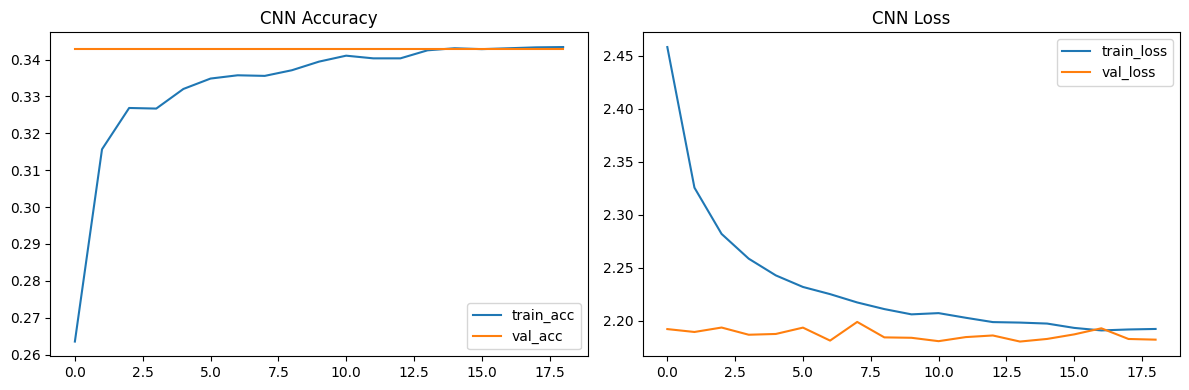

In [40]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(train_acc, label="train_acc")
axs[0].plot(val_acc, label="val_acc")
axs[0].set_title("CNN Accuracy")
axs[0].legend()

axs[1].plot(train_loss, label="train_loss")
axs[1].plot(val_loss, label="val_loss")
axs[1].set_title("CNN Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [41]:
model.save('cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
